In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import Bidirectional
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.constraints import maxnorm
from keras.models import model_from_json
from keras.optimizers import Adam
from keras import regularizers

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score


In [0]:
data = pd.read_csv("drive/My Drive/final_data.csv")

In [4]:
data.head()

,Unnamed: 0,persons covered treaty eligibility precily whether an llc s corporation is entitled to tax treaty benefits,pe precily construction installation pe,pe precily service pe,pe precily employee deputation,pe precily supervisory pe,pe precily force of attraction,pe precily profit attribution,pe precily fixed place pe,pe precily agency pe dape,pe precily others,business profits precily source of income,shipping air transport precily source of income from shipping air transport,shipping air transport precily slot charters,shipping air transport precily activities directly connected with transportation of ship,interest precily usance interest,interest precily taxability of discounting charges,interest precily payment on ccds,interest precily interest payments by branch and head office interse,interest precily others,royalty precily payment for leased line circuit connectivity charges,royalty precily software as a platform (saap) v software as a service (saas),royalty precily exclusive distribution rights broadcasting rights,royalty precily payments for shrinked wrapped software,royalty precily payments for online access to database,royalty precily fees for use of satellite,royalty precily payment for knowhow designs engineering drawings etc,royalty precily equipment process royalty,royalty precily others,royaltyfts precily data processing whether royaltyfts,royaltyfts precily taxability of content delivery solutions,royaltyfts precily others,fts precily payments for technical reports,fts precily payments for standard facilities,fts precily payment for mineral oil exploration and related activities,fts precily payments towards reimbursement of expenses,fts precily payments made for training of employees of foreign companies,fts precily services inextricably linked,fts precily fts importance of human intervention,fts precily absence of fts clause in treaty business profits or other income,...,capital gains precily capital gains vs business income,capital gains precily joint development agreements (jda),capital gains precily slump sale (section 50b),capital gains precily buy back of sharescapital reduction,other sources precily gifts,other sources precily taxability of interest income on surplus capital subsidy from government of india,other sources precily capital subsidy prior to amendment in section 2,other sources precily others,unexplained income precily section 68 cash credits,unexplained income precily section 69 unexplained investments,unexplained income precily others,chapter via deductions precily deduction in respect of certain incomes,chapter via deductions precily others,minimum alternate tax precily computation of book profit,minimum alternate tax precily mat credit entitlement offset,minimum alternate tax precily others,prosecution precily initiation of prosecution proceedings,prosecution precily others,interest (interest on income tax refund) precily interest on income tax refund,interest (interest on income tax refund) precily others,carry forward of losses precily period of carry forward of losses in case of amalgamation,carry forward of losses precily year of cf of loss to the amalgamated company,carry forward of losses precily others,penalty precily levy of penalty 271(1)( c),penalty precily 271f failure to furnish roi,penalty precily others,dispute resolution precily assessment proceedings us 143(3) and reassessment us 147,dispute resolution precily powers of drp ( dispute resolution panel),dispute resolution precily grant of stay,dispute resolution precily time barred order under section 153 ( barred by limitation of law),dispute resolution precily condonation of delay in filing of appeal,dispute resolution precily non filing of appeal against addition does not tantamount to acceptance,dispute resolution precily passing of draft assessment order in case of eligible assessee section 144c,dispute resolution precily invoking of rule 27 of tribunal rules,section 9 precily retrospective amendment in section 9 

In [5]:
data.columns

Index(['Unnamed: 0',
       'persons covered treaty eligibility precily whether an llc s corporation is entitled to tax treaty benefits',
       'pe precily construction installation pe', 'pe precily service pe',
       'pe precily employee deputation', 'pe precily supervisory pe',
       'pe precily force of attraction', 'pe precily profit attribution',
       'pe precily fixed place pe', 'pe precily agency pe dape',
       ...
       'dispute resolution precily condonation of delay in filing of appeal',
       'dispute resolution precily non filing of appeal against addition does not tantamount to acceptance',
       'dispute resolution precily passing of draft assessment order in case of eligible assessee section 144c',
       'dispute resolution precily invoking of rule 27 of tribunal rules',
       'section 9 precily retrospective amendment in section 9 by finance act 2012',
       'section 9 precily others',
       'refund processing section 143(1d) precily others',
       'divid

In [0]:
data.drop("Unnamed: 0",inplace=True,axis=1)

In [0]:
# F1 Score
def f1_score(y_true, y_pred):
	"""
	Compute the micro f(b) score with b=1.
	"""
	y_true = tf.cast(y_true, "float32")
	y_pred = tf.cast(tf.round(y_pred), "float32") # implicit 0.5 threshold via tf.round
	y_correct = y_true * y_pred


	sum_true = tf.reduce_sum(y_true, axis=1)
	sum_pred = tf.reduce_sum(y_pred, axis=1)
	sum_correct = tf.reduce_sum(y_correct, axis=1)


	precision = sum_correct / sum_pred
	recall = sum_correct / sum_true
	f_score = 2 * precision * recall / (precision + recall)
	f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)


	return tf.reduce_mean(f_score)

In [0]:
from sklearn.model_selection import train_test_split

In [10]:
data.shape

(117704, 123)

In [0]:
train, validation = train_test_split(data,test_size=0.2,random_state=123)
train,test = train_test_split(train,test_size=0.18,random_state=123)

In [12]:
train.shape

(77213, 123)

In [13]:
validation.shape

(23541, 123)

In [14]:
test.shape

(16950, 123)

In [0]:
features_train = train["para"]
features_valid = validation["para"]
features_test = test["para"]

In [0]:
y_train = train.iloc[:,:-1]
y_test = test.iloc[:,:-1]
y_valid = validation.iloc[:,:-1]

In [23]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("drive/My Drive/ content glove glove.42B.300d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 1917494 word vectors.


In [0]:
MAX_VOCAB_SIZE = 80000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(features_train)
sequences_train = tokenizer.texts_to_sequences(features_train)
sequences_test = tokenizer.texts_to_sequences(features_test)

In [0]:
sequences_valid = tokenizer.texts_to_sequences(features_valid)

In [28]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 585471 unique tokens.


In [0]:
length = []

for i in sequences_train:

  length.append(len(i))

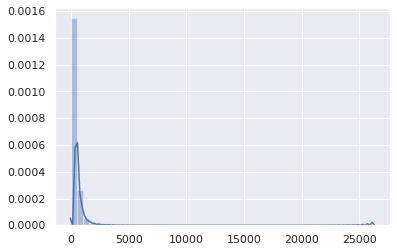

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.distplot(length)

In [0]:
MAX_SEQUENCE_LENGTH = 500

In [33]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_train.shape)
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_test.shape)
encoded_valid = pad_sequences(sequences_valid, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_valid.shape)

Shape of data tensor: (77213, 500)
Shape of data tensor: (16950, 500)
Shape of data tensor: (23541, 500)


In [34]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Filling pre-trained embeddings...
(80000, 300)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, load_model 
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D,Dense, Embedding, Input, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [42]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1,
                                                      recurrent_dropout=0.1))(x)
 
x = Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
 
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
 
x = concatenate([avg_pool, max_pool])
 
preds = Dense(122, activation="sigmoid")(x)
 
model = Model(input_, preds)
 

 
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=[f1_score])

Building model...


In [0]:
# Callbacks
model_3 = ModelCheckpoint('model_bilstm_multilabel_2.h5', save_best_only=True, monitor='val_loss', mode='min')
logdir = "logs/model_bilstm_multilabel/"
tensorboard_callback = TensorBoard(log_dir=logdir)

In [44]:
print('Training model...')
r = model.fit(
  encoded_train,
  y_train,
  batch_size=512,
  epochs=10,
  validation_data=(encoded_valid,y_valid),callbacks=[tensorboard_callback,model_3]
)

Training model...
Train on 77213 samples, validate on 23541 samples
Epoch 1/10
77213/77213 [==============================] - 257s 3ms/step - loss: 0.1881 - f1_score: 0.0453 - val_loss: 0.1230 - val_f1_score: 0.1068

Epoch 2/10
77213/77213 [==============================] - 250s 3ms/step - loss: 0.1068 - f1_score: 0.1711 - val_loss: 0.0932 - val_f1_score: 0.2333
Epoch 3/10
77213/77213 [==============================] - 248s 3ms/step - loss: 0.0882 - f1_score: 0.2689 - val_loss: 0.0825 - val_f1_score: 0.3104
Epoch 4/10
77213/77213 [==============================] - 246s 3ms/step - loss: 0.0792 - f1_score: 0.3382 - val_loss: 0.0755 - val_f1_score: 0.3886
Epoch 5/10
77213/77213 [==============================] - 244s 3ms/step - loss: 0.0730 - f1_score: 0.3947 - val_loss: 0.0704 - val_f1_score: 0.4322
Epoch 6/10
77213/77213 [==============================] - 244s 3ms/step - loss: 0.0682 - f1_score: 0.4412 - val_loss: 0.0670 - val_f1_score: 0.4588
Epoch 7/10
77213/77213 [===================

In [45]:
result = model.evaluate(encoded_test,y_test,batch_size=128)

16950/16950 [==============================] - 63s 4ms/step


In [46]:
result

[0.05890754989026922, 0.5452371490107173]